In [1]:
#Importar Librerías
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker import LinearLearner
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sagemaker.tuner import HyperparameterTuner

#from sagemaker import Session

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Para clasificación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Para regresión
from sklearn.metrics import confusion_matrix, classification_report  # Para evaluación general en clasificación

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


## Acerca del conjunto de datos

•	El conjunto de datos contiene un número total de: 1000 registros.
•	Tamaño del conjunto de entrenamiento: 800 registros.
•	Tamaño del conjunto de prueba: 200 registros.
•	Número de clases: 3 (tipos de clientes).

In [2]:
#Cargar el Dataset a una variable

# Variables para la conexión
role = get_execution_role()
bucket = 'sagemaker-test-api-bucket20'  # Nombre del bucket
data_key = 'proyecto_dir20/synthetic_customer_data.csv'  # Ruta del archivo en el bucket
data_location = f's3://{bucket}/{data_key}'

In [3]:
# Cargar el dataset con opciones de almacenamiento
df = pd.read_csv(data_location, storage_options={"anon": False})

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [4]:
df.head() #Ver los primeros cinco registros del dataset

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,Male,65648,49624.926758,17,467.729972,52.525842,0,235,61,medium_value
1,CUST_0002,69,Male,123537,46357.348299,196,874.799829,11.120875,0,182,48,medium_value
2,CUST_0003,46,Male,145991,27043.860801,175,207.419293,86.816930,0,199,50,medium_value
3,CUST_0004,32,Female,29516,42117.461389,25,131.749484,29.736153,0,356,32,medium_value
4,CUST_0005,60,Male,132863,26095.803066,94,289.081236,16.253799,1,245,29,high_value


In [5]:
df.info() #Obtener información sobre el dataset y verificar la presencia de valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1000 non-null   object 
 1   age                       1000 non-null   int64  
 2   gender                    1000 non-null   object 
 3   annual_income             1000 non-null   int64  
 4   total_spent               1000 non-null   float64
 5   num_purchases             1000 non-null   int64  
 6   avg_purchase_value        1000 non-null   float64
 7   online_activity_score     1000 non-null   float64
 8   loyalty_program           1000 non-null   int64  
 9   days_since_last_purchase  1000 non-null   int64  
 10  num_site_visits           1000 non-null   int64  
 11  customer_segment          1000 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 93.9+ KB


In [6]:
# Asegurar coincidencia exacta en todas las subcategorías
df['customer_segment'] = df['customer_segment'].str.lower().str.strip()
print(df['customer_segment'].unique())

# Mapeo manual de las categorías
df['customer_segment'] = df['customer_segment'].map({
    'low_value': 0,
    'medium_value': 1,
    'high_value': 2
})

['medium_value' 'high_value' 'low_value']


In [7]:
print(df['customer_segment'].unique())

[1 2 0]


In [8]:
# Asegurar coincidencia exacta en todas las subcategorías
df['gender'] = df['gender'].str.lower().str.strip()
print(df['gender'].unique())

['male' 'female']


In [9]:
#Convertir la variable categórica gender a numérica
df['gender'] = df['gender'].map({'male': 0, 'female': 1})

In [10]:
df.head()

,customer_id,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
0,CUST_0001,56,0,65648,49624.926758,17,467.729972,52.525842,0,235,61,1
1,CUST_0002,69,0,123537,46357.348299,196,874.799829,11.120875,0,182,48,1
2,CUST_0003,46,0,145991,27043.860801,175,207.419293,86.816930,0,199,50,1
3,CUST_0004,32,1,29516,42117.461389,25,131.749484,29.736153,0,356,32,1
4,CUST_0005,60,0,132863,26095.803066,94,289.081236,16.253799,1,245,29,2


Visualizar la existencia de Outliers

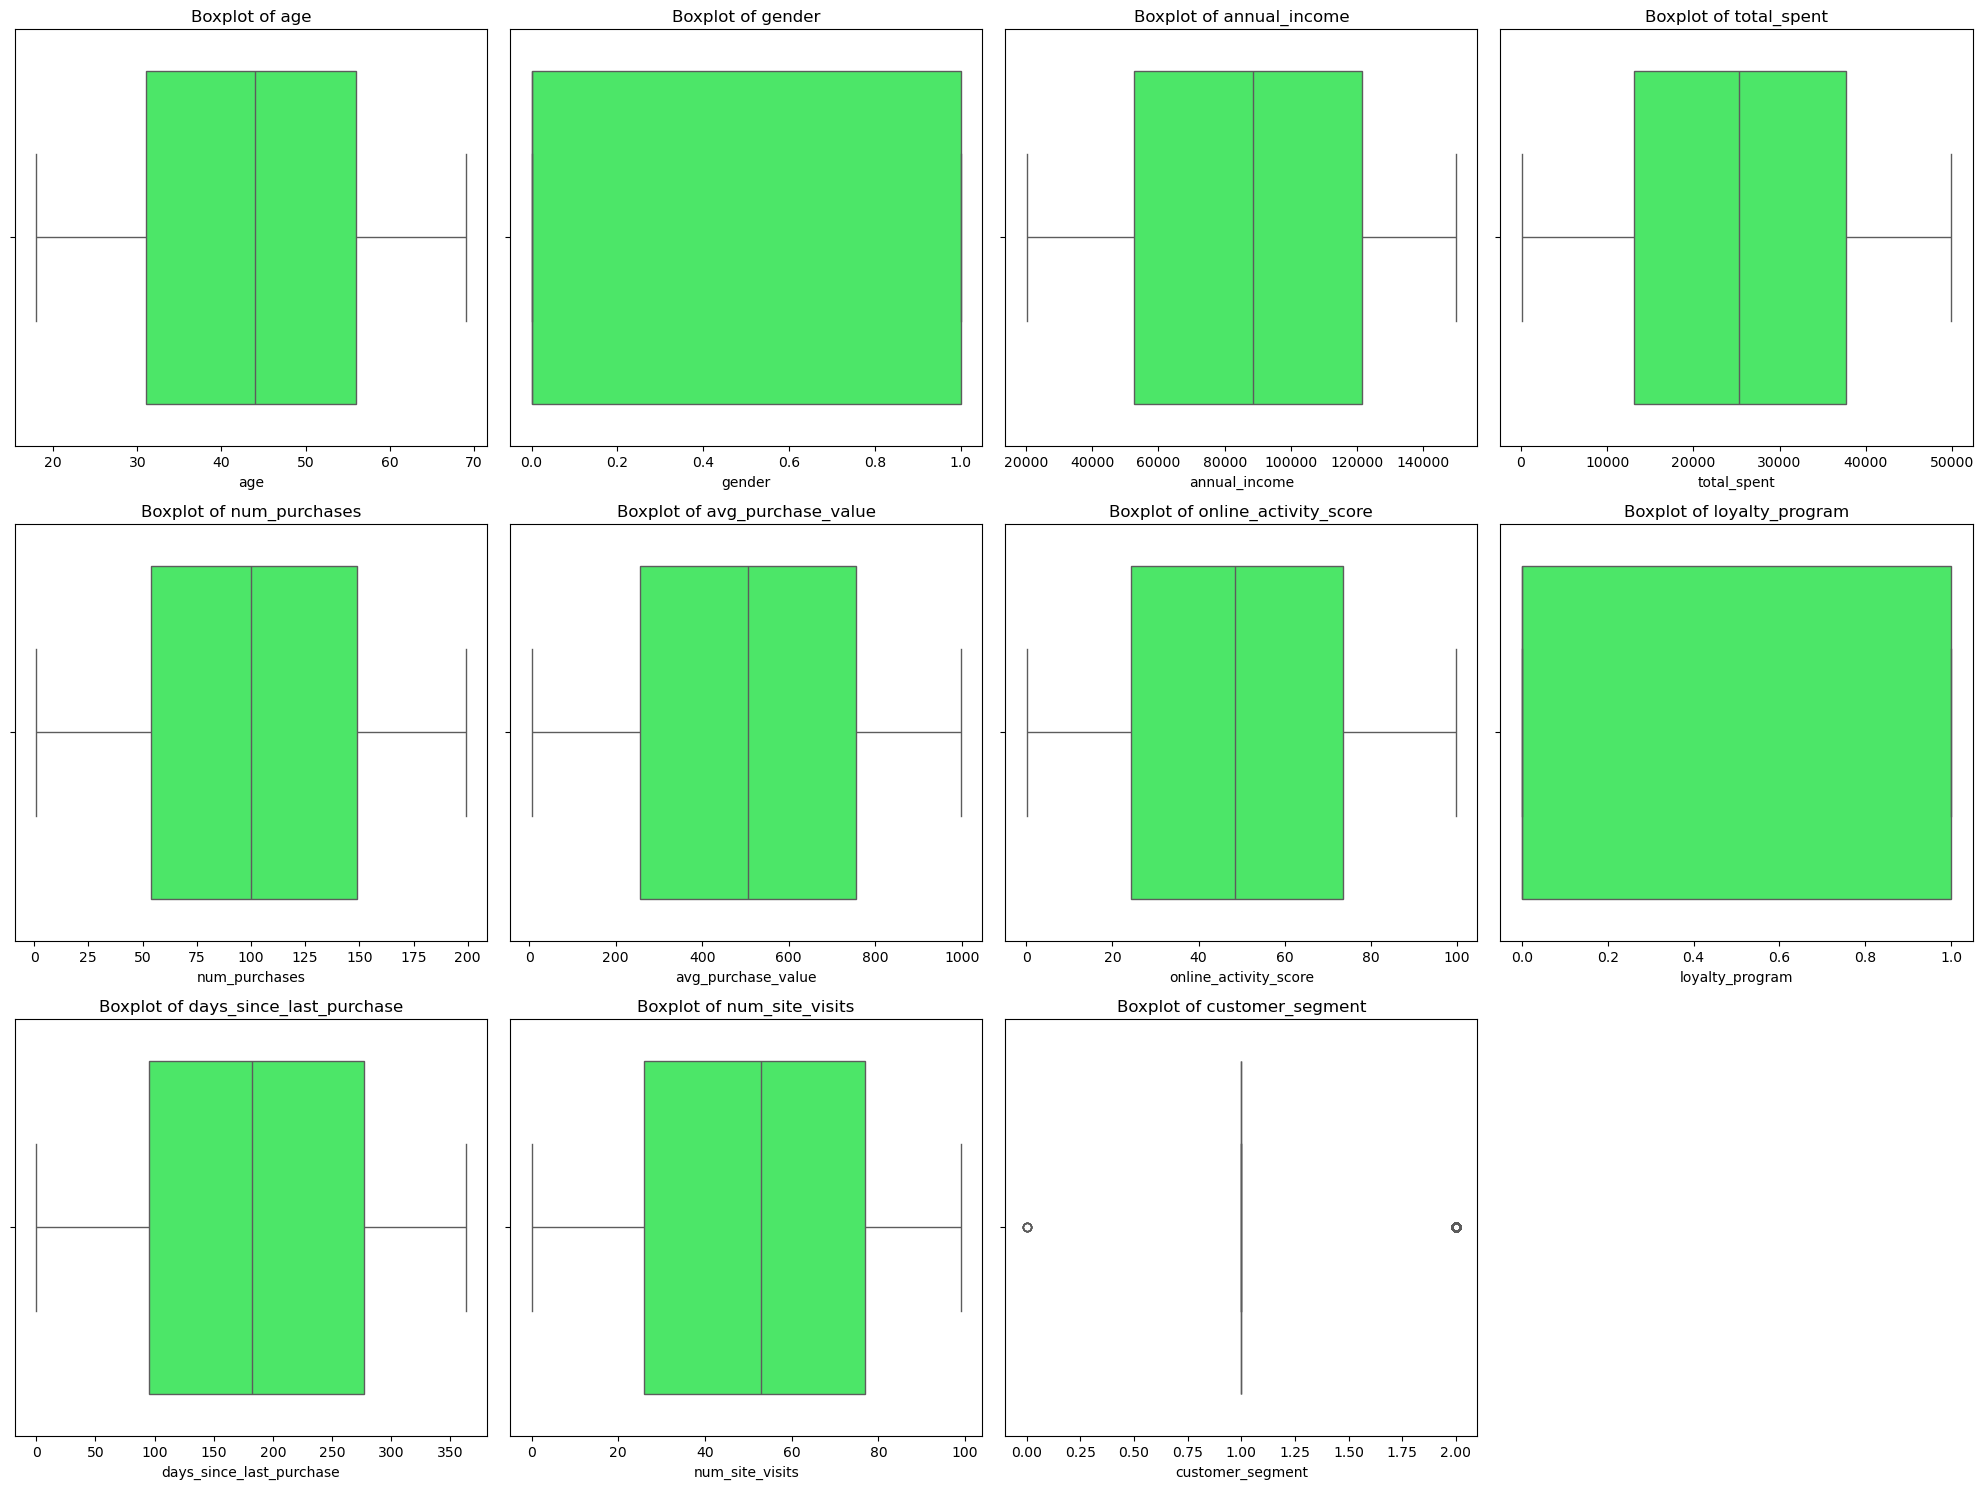

In [11]:
# Filtrar columnas numéricas con al menos dos valores únicos
numeric_cols = [col for col in df.select_dtypes(include=['int', 'float']).columns if df[col].nunique() > 1]

# Configurar el número de filas y columnas
num_cols = 4  # Máximo de gráficos por fila
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

# Crear figura con un subgráfico para cada columna, en una cuadrícula de 2x5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Aplanar los ejes para iterar fácilmente y esconder los gráficos vacíos
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color="#33FF57")
    axes[i].set_title(f'Boxplot of {col}')
    
    # Eliminar cualquier gráfico vacío en la cuadrícula
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# Estandarizar/Normalizar variables numéricas
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['age', 'annual_income', 'total_spent', 'num_purchases', 'avg_purchase_value', 'online_activity_score',
    'days_since_last_purchase', 'num_site_visits']] = scaler.fit_transform(df[['age', 'annual_income',
    'total_spent', 'num_purchases', 'avg_purchase_value', 'online_activity_score', 'days_since_last_purchase',
    'num_site_visits']])

In [13]:
df.describe() #Obtener las estadísticas descriptivas de las columnas numéricas
#Visualizar la existencia de Outliers

,age,gender,annual_income,total_spent,num_purchases,avg_purchase_value,online_activity_score,loyalty_program,days_since_last_purchase,num_site_visits,customer_segment
count,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,-1.634248e-16,0.476000,1.048051e-16,-5.062617e-17,4.973799e-17,2.309264e-16,4.263256e-17,0.289000,-9.237056e-17,9.592327e-17,1.130000
std,1.000500e+00,0.499674,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.453525,1.000500e+00,1.000500e+00,0.353872
min,-1.723158e+00,0.000000,-1.746715e+00,-1.732114e+00,-1.762860e+00,-1.733979e+00,-1.716971e+00,0.000000,-1.761541e+00,-1.777414e+00,0.000000
25%,-8.555393e-01,0.000000,-8.980375e-01,-8.339142e-01,-8.195260e-01,-8.578916e-01,-8.625125e-01,0.000000,-8.514117e-01,-8.744857e-01,1.000000
50%,1.207993e-02,0.000000,3.526967e-02,1.722782e-02,-7.831453e-04,1.464792e-02,-2.015594e-02,0.000000,-1.313460e-02,6.317022e-02,1.000000
75%,8.129592e-01,1.000000,8.943481e-01,8.774285e-01,8.713559e-01,8.820597e-01,8.672596e-01,1.000000,8.922047e-01,8.966421e-01,1.000000
max,1.680578e+00,1.000000,1.636694e+00,1.722187e+00,1.761294e+00,1.725767e+00,1.785272e+00,1.000000,1.716111e+00,1.660658e+00,2.000000


## División de los datos para el entrenamiento

In [14]:
# División en conjunto de entrenamiento y validación
X = df.drop(columns=['customer_id', 'customer_segment'])
y = df['customer_segment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de X_train:", len(X_train))

Tamaño de X_train: 800


In [15]:
# Confirmar que no quedan valores NaN restantes
print("Valores NaN en X_train:", X_train.isnull().sum().sum())
print("Valores NaN en y_train:", y_train.isnull().sum().sum())

Valores NaN en X_train: 0
Valores NaN en y_train: 0


In [16]:
# Inicialización de sesión y rol
role = get_execution_role()  # Asegúrate de que el rol esté correctamente definido
session = Session()

In [17]:
# Preparar el entorno para el modelo
s3_prefix = 'customer-classification'
output_path = 's3://{}/{}/'.format(bucket, s3_prefix)

In [18]:
# Instanciar el modelo de LinearLearner como clasificador multicategoría
session = sagemaker.Session()
linear = LinearLearner(role=role,
                       instance_count=1,
                       instance_type='ml.m4.xlarge',
                       predictor_type='multiclass_classifier',
                       output_path=output_path,
                       sagemaker_session=session,
                       epochs=20,
                       num_classes=3  # Cambia este valor al número real de categorías
                      )

## Definir Hiperparámetros

In [19]:
# Definir los rangos de hiperparámetros VER
hyperparameter_ranges = {
    'learning_rate': sagemaker.tuner.ContinuousParameter(0.001, 0.1),
    'mini_batch_size': sagemaker.tuner.IntegerParameter(50, 200),
}

In [20]:
# Configurar el trabajo de ajuste de hiperparámetros  VER
tuner = HyperparameterTuner(
    estimator=linear,
    objective_metric_name="validation:accuracy",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2
)

In [21]:
# Convertir datos de entrenamiento a RecordSet
training_recordset = linear.record_set(X_train.values.astype('float32'), labels=y_train.values.astype('float32'))

## Entrenamiento del modelo

In [22]:
# Entrenar el modelo
model =linear.fit(training_recordset)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-14-02-07-53-974


2024-11-14 02:07:55 Starting - Starting the training job...
2024-11-14 02:08:29 Starting - Preparing the instances for training......
2024-11-14 02:09:25 Downloading - Downloading the training image............
2024-11-14 02:11:17 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/14/2024 02:11:30 INFO 139670864750400] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_in

In [27]:
#SERIALIZADO
from joblib import dump
import joblib
import os

# Directorio para guardar el modelo
output_dir = 'proyecto_dir20'
os.makedirs(output_dir, exist_ok=True)  # Crear el directorio si no existe

# Ruta completa del archivo donde se guardará el modelo
model_path = os.path.join(output_dir, 'customer_classification_model.joblib')

# Guardar el modelo entrenado en la ruta especificada
dump(model, model_path)

print(f"Modelo guardado correctamente en: {model_path}")


# Guardar el modelo entrenado

# Define el directorio del modelo para guardarlo
model_dir = os.environ.get("SM_MODEL_DIR", "./model")  # Usa './model' como directorio local si SM_MODEL_DIR no está definido
os.makedirs(model_dir, exist_ok=True)  # Crea el directorio si no existe

# Guardar el modelo
joblib.dump(model, os.path.join(model_dir, "model.joblib"))

# Función model_fn para deserializar y cargar el modelo en el punto de despliegue
def model_fn(model_dir):
    """Deserializa y retorna el modelo entrenado"""
    model_serializado = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model_serializado


Modelo guardado correctamente en: proyecto_dir20/customer_classification_model.joblib


In [28]:
import joblib
import os

def model_fn(model_dir):
    """Deserializa y retorna el modelo entrenado"""
    model_path = os.path.join(model_dir, "customer_classification_model.joblib")
    if os.path.exists(model_path):
        clf = joblib.load(model_path)
        return clf
    else:
        raise FileNotFoundError(f"Modelo no encontrado en la ruta: {model_path}")

In [29]:
# ENDPOINT
predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-14-02-57-56-104
INFO:sagemaker:Creating endpoint-config with name linear-learner-2024-11-14-02-57-56-104
INFO:sagemaker:Creating endpoint with name linear-learner-2024-11-14-02-57-56-104


-----------------!

In [30]:
# Realizar predicciones en el conjunto de prueba
y_pred = np.array([int(result.label['predicted_label'].float32_tensor.values[0]) for result in predictor.predict(X_test.values.astype('float32'))])

In [31]:
# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)#Desplegar el Modelo entrenado y Obtener nombre del EndPoint

Accuracy: 0.935
Precision: 0.9395675675675677
Recall: 0.935
F1-score: 0.9263578919940069


In [32]:
# Nombre del endpoint
print(f'Endpoint name: {predictor.endpoint}')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: linear-learner-2024-11-14-02-57-56-104


##  Eliminar monitor

In [ ]:
import subprocess
import json

# Ejecuta el comando AWS CLI para listar los cronogramas de monitoreo
command = "aws sagemaker list-monitoring-schedules"
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Imprime el resultado
if result.returncode == 0:
    # Si el comando se ejecutó correctamente, parsea el JSON y lo muestra
    monitoring_schedules = json.loads(result.stdout)
    print(json.dumps(monitoring_schedules, indent=2))
else:
    # Si hubo un error al ejecutar el comando, muestra el mensaje de error
    print(f"Error: {result.stderr}")

In [ ]:
import subprocess

# Nombre del cronograma de monitoreo
monitor_name = "hora-data-quality-monitor20"

# Comando para detener el cronograma de monitoreo
command = f"aws sagemaker stop-monitoring-schedule --monitoring-schedule-name {monitor_name}"

# Ejecuta el comando
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Verifica si el comando fue exitoso
if result.returncode == 0:
    print(f"Monitoreo '{monitor_name}' detenido correctamente.")
else:
    print(f"Error al detener el monitoreo: {result.stderr}")

In [ ]:
import boto3

# Inicializa el cliente de SageMaker
sagemaker_client = boto3.client('sagemaker')

# Nombre del monitoreo que deseas eliminar
monitoring_schedule_name = 'hora-data-quality-monitor20'

# Eliminar el monitoreo
response = sagemaker_client.delete_monitoring_schedule(
    MonitoringScheduleName=monitoring_schedule_name
)

# Imprimir la respuesta
print("Monitoreo eliminado:", response)

In [ ]:
predictor.delete_endpoint()